In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

In [14]:
df_numeric = joblib.load('df_numeric.pkl')

In [15]:
# Copy df_numeric to start creating df_unsupervised
df_unsupervised = df_numeric.copy()

# Least influential encoded columns to drop
least_influential = {
    'no_employees_encoded', 
    'remote_work_encoded', 
    'tech_company_encoded', 
    'self_employed_encoded',
    'Country_encoded', 
    'state_encoded', 
    'Gender_encoded', 
    'Age', 
    'Timestamp_encoded', 
    'comments_encoded'
}

# Drop least influential columns safely
df_unsupervised.drop(columns=list(least_influential), inplace=True, errors='ignore')

# Moderately influential encoded columns to combine into 'openness'
moderately_influential_encoded = [
    'supervisor_encoded', 'coworkers_encoded', 'mental_health_consequence_encoded', 
    'obs_consequence_encoded', 'wellness_program_encoded', 'phys_health_consequence_encoded',
    'mental_health_interview_encoded', 'phys_health_interview_encoded'
]

# Create 'openness' feature as sum of moderately influential features
df_unsupervised['openness'] = df_unsupervised[moderately_influential_encoded].sum(axis=1)

# Drop the original moderately influential encoded features
df_unsupervised.drop(columns=moderately_influential_encoded, inplace=True)


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


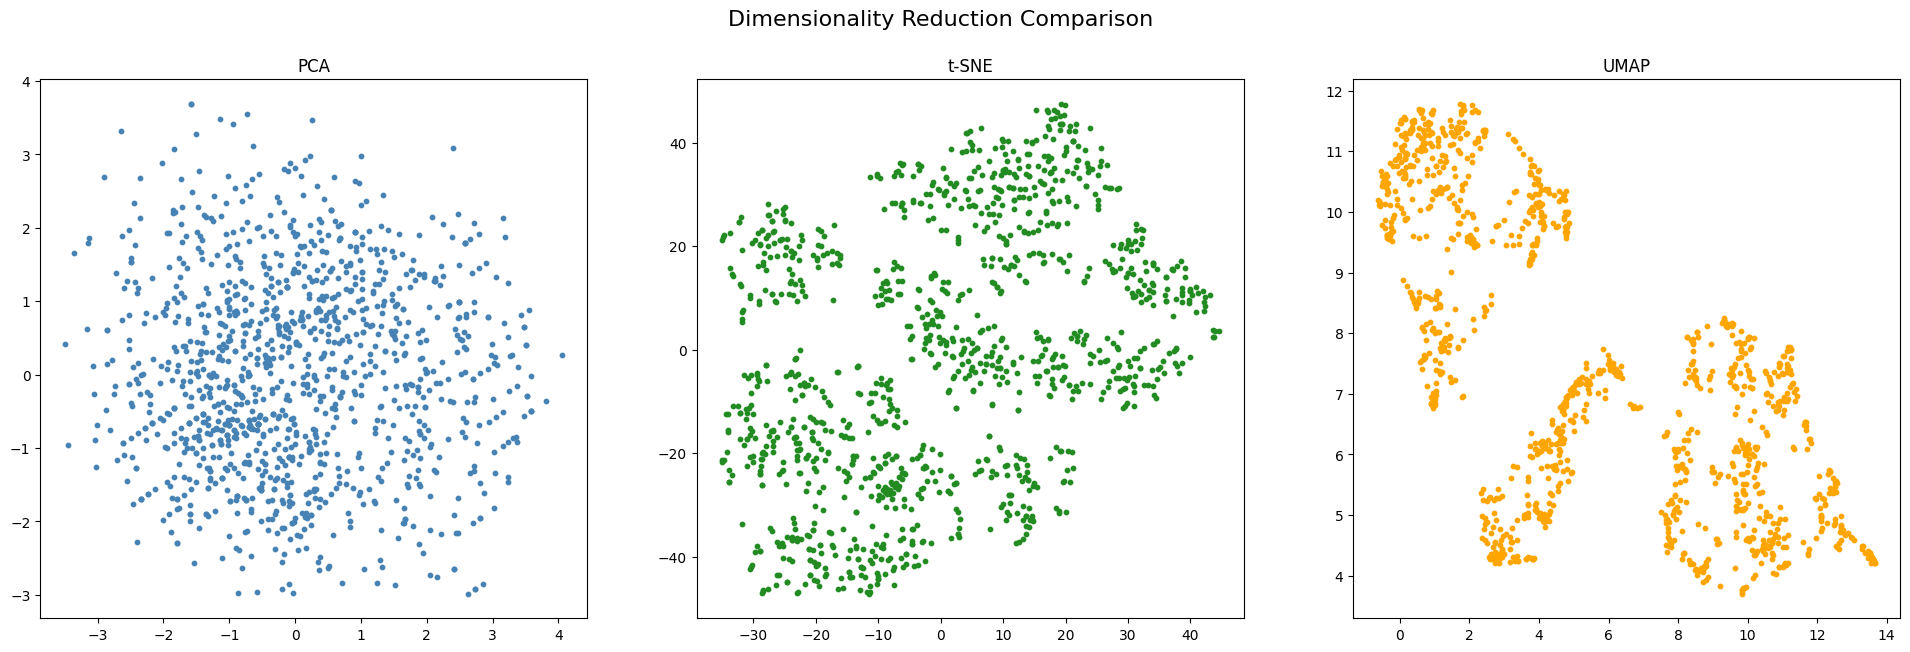

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_unsupervised)

# PCA
X_pca = PCA(n_components=2, random_state=42).fit_transform(X_scaled)

# t-SNE
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_scaled)

# UMAP
X_umap = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1, random_state=42).fit_transform(X_scaled)

# Plot all three
fig, ax = plt.subplots(1, 3, figsize=(24, 7))
ax[0].scatter(X_pca[:, 0], X_pca[:, 1], s=10, c='steelblue')
ax[0].set_title('PCA')
ax[1].scatter(X_tsne[:, 0], X_tsne[:, 1], s=10, c='forestgreen')
ax[1].set_title('t-SNE')
ax[2].scatter(X_umap[:, 0], X_umap[:, 1], s=10, c='orange')
ax[2].set_title('UMAP')
plt.suptitle('Dimensionality Reduction Comparison', fontsize=16)
plt.show()

In [17]:
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_umap)
    score = silhouette_score(X_umap, labels)
    sil_scores.append([k, score])
    print(f"k = {k}: {score:.4f}")

best_k, best_score = max(sil_scores, key=lambda x: x[1])
print(f"\nHighest Silhouette Score is for k = {best_k}")

k = 2: 0.5892
k = 3: 0.5529
k = 4: 0.4626
k = 5: 0.4349
k = 6: 0.4644
k = 7: 0.4968
k = 8: 0.5056
k = 9: 0.4862
k = 10: 0.4986

Highest Silhouette Score is for k = 2


In [18]:
# K-Means
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_umap)

# Agglomerative
agg = AgglomerativeClustering(n_clusters=best_k)
agg_labels = agg.fit_predict(X_umap)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_umap)

In [19]:
print("Clustering Performance Evaluation:")

# K-Means
print(f"K-Means Silhouette Score: {silhouette_score(X_umap, kmeans_labels):.4f}")
print(f"K-Means Clusters: {len(np.unique(kmeans_labels))}")

# Agglomerative
print(f"Agglomerative Silhouette Score: {silhouette_score(X_umap, agg_labels):.4f}")
print(f"Agglomerative Clusters: {len(np.unique(agg_labels))}")

# DBSCAN
db_mask = dbscan_labels != -1
if np.sum(db_mask) > 0:
    db_score = silhouette_score(X_umap[db_mask], dbscan_labels[db_mask])
    n_clusters_dbscan = len(np.unique(dbscan_labels[dbscan_labels != -1]))
    n_noise = np.sum(dbscan_labels == -1)
    print(f"DBSCAN Silhouette Score: {db_score:.4f}")
    print(f"DBSCAN Clusters: {n_clusters_dbscan}, Noise Points: {n_noise}")
else:
    print("DBSCAN: No valid clusters found")

Clustering Performance Evaluation:
K-Means Silhouette Score: 0.5892
K-Means Clusters: 2
Agglomerative Silhouette Score: 0.5882
Agglomerative Clusters: 2
DBSCAN Silhouette Score: 0.3748
DBSCAN Clusters: 5, Noise Points: 0


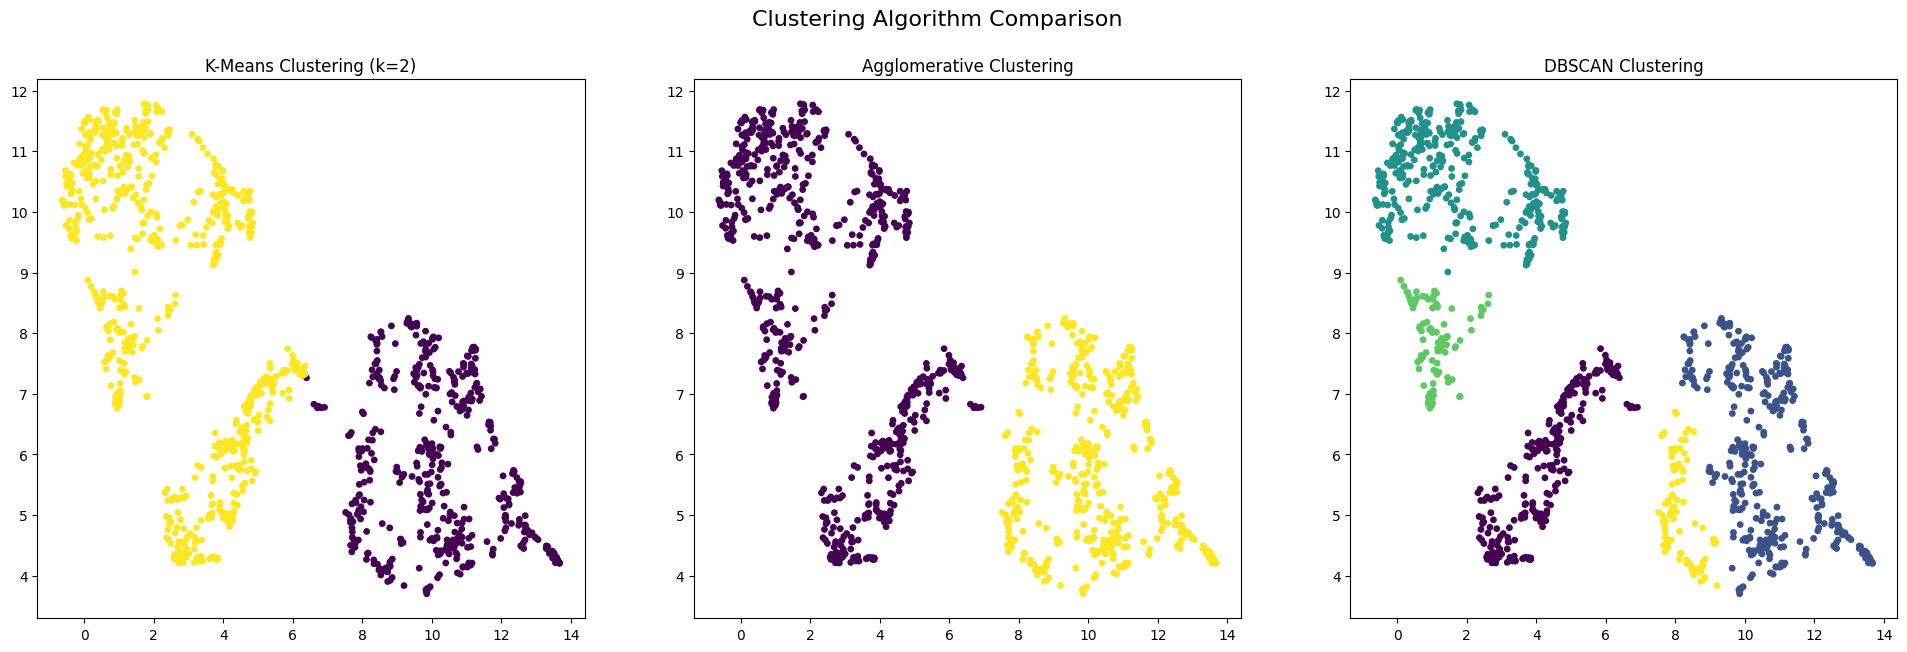

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 7))

ax1.scatter(X_umap[:, 0], X_umap[:, 1], c=kmeans_labels, cmap='viridis', s=15)
ax1.set_title(f'K-Means Clustering (k={best_k})')

ax2.scatter(X_umap[:, 0], X_umap[:, 1], c=agg_labels, cmap='viridis', s=15)
ax2.set_title('Agglomerative Clustering')

ax3.scatter(X_umap[:, 0], X_umap[:, 1], c=dbscan_labels, cmap='viridis', s=15)
ax3.set_title('DBSCAN Clustering')

plt.suptitle('Clustering Algorithm Comparison', fontsize=16)
plt.show()